# Streaming analysis of stock prices

In [85]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob


In [86]:
%cd /Users/yoavfreund/BigData/stocksDataset/spdata\ 2
!ls -l | head

/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/stocksDataset/spdata 2
total 57912
-rw-r--r--@ 1 yoavfreund  503  64924 Apr 16 17:21 A.csv
-rw-r--r--@ 1 yoavfreund  503  61366 Apr 16 17:22 AA.csv
-rw-r--r--@ 1 yoavfreund  503  62032 Apr 16 17:22 AAPL.csv
-rw-r--r--@ 1 yoavfreund  503  61694 Apr 16 17:22 ABC.csv
-rw-r--r--@ 1 yoavfreund  503  63140 Apr 16 17:22 ABT.csv
-rw-r--r--@ 1 yoavfreund  503  63515 Apr 16 17:22 ACE.csv
-rw-r--r--@ 1 yoavfreund  503  62960 Apr 16 17:22 ACN.csv
-rw-r--r--@ 1 yoavfreund  503  43254 Apr 16 17:22 ADBE.csv
-rw-r--r--@ 1 yoavfreund  503  57459 Apr 16 17:22 ADI.csv


In [170]:
Tables={}
for filename in glob('*.csv'):
    tbl=pd.read_csv(filename,index_col='Date')
    code = filename[:-4]
    if(np.shape(tbl)[1]==12):
        Tables[code]=tbl.sort_index()
        Tables[code]
    else:
        print filename,np.shape(tbl)


BF.B.csv (0, 1)
BMC.csv (0, 1)
BRK.B.csv (0, 1)
CVH.csv (0, 1)
HNZ.csv (0, 1)
LTD.csv (0, 1)
MHP.csv (0, 1)
MOLX.csv (0, 1)
NYX.csv (0, 1)
PCS.csv (0, 1)
SAI.csv (0, 1)
TIE.csv (0, 1)
WPI.csv (0, 1)
WPO.csv (0, 1)


In [201]:
Daily=None
Diffs=None
#print np.shape(SR)
for code in Tables.keys():
    tbl=Tables[code]
    SR=tbl['Split Ratio']
    CSR=np.cumsum(SR.apply(math.log)).apply(math.exp)
    S=np.multiply(tbl['Open'],CSR)
    if type(Daily)==type(None):
        I=S.index
        Diffs=pd.DataFrame(index=I[:-1])
        Daily=pd.DataFrame(index=I)
    S=S/S.mean()
    Daily[code]=S       # The pandas Series S will be merged into Dily according to the indices.
    prices=np.array(S)  # The length of "prices" will remain the original length.
    diff=prices[1:]-prices[:-1]
    I=S.index
    I=I[1:]
    #print np.shape(Diffs),np.shape(Sdiff),np.shape(diff),len(I)
    Sdiff=pd.DataFrame(diff,index=I,columns=[code])
    Diffs=Diffs.join(Sdiff)

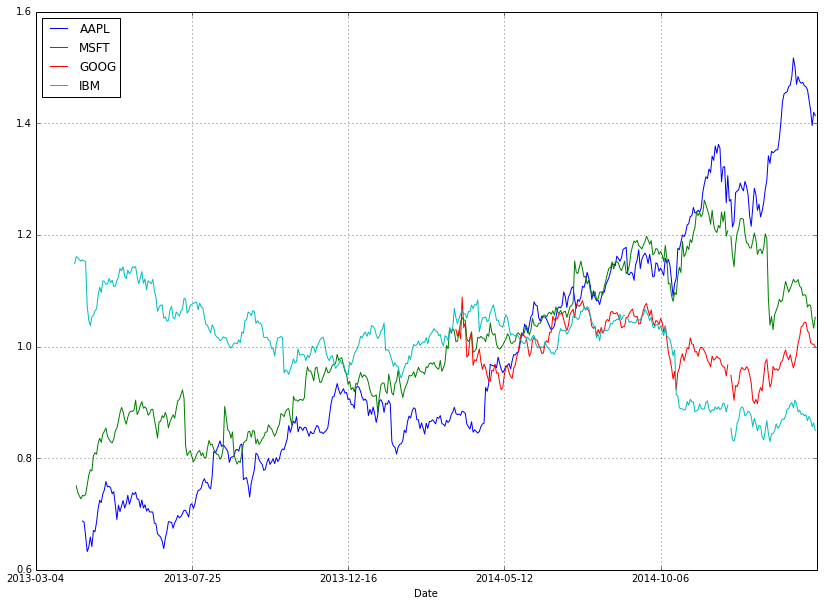

In [168]:
Daily[['AAPL','MSFT','GOOG','IBM']].plot(figsize=(14,10))

In [240]:
from sklearn.decomposition import PCA
D=np.array(Diffs.fillna(0)).transpose()
print np.shape(D)
meanStock=np.mean(D,axis=0)
print np.shape(meanStock)
CD=D-meanStock.transpose()
df = pd.DataFrame(data=CD)

pca = PCA(n_components=5)
pca.fit(df)

(485, 499)
(499,)


PCA(copy=True, n_components=5, whiten=False)

In [242]:
pca.explained_variance_ratio_

array([ 0.21724797,  0.04434889,  0.0301444 ,  0.02701424,  0.02509466])

In [243]:
tdf = pca.transform(df)
np.shape(tdf)

(485, 5)

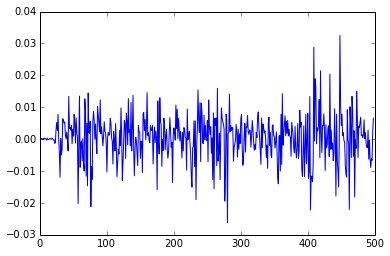

In [244]:
plt.plot(meanStock)

400

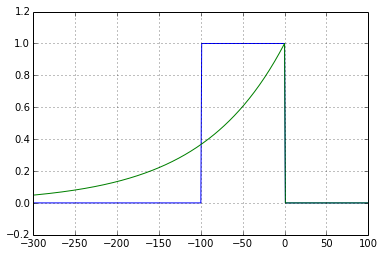

In [2]:
T=100
alpha=1.0/T
window=np.concatenate((np.zeros(T),np.ones(T),np.zeros(2*T)))
exponential=np.array(window)
for i in range(T+1,4*T):
    exponential[i]=exponential[i-1]*(1-alpha)
plt.plot(range(T,-3*T,-1),window)
plt.plot(range(T,-3*T,-1),exponential)
plt.ylim([-0.2,1.2])
plt.grid()
len(window)

##### Implementation
We now implement these estimators using classes that are a special case fo python **Iterators**.

In [3]:
# Using the generator pattern (an iterable)
class run_aver:
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = 0.0
        self.alpha = alpha

    def send(self,x):
        if self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=x-self.s
        return residual
    
    def get_state(self):
        return self.s

# compute the variance of a signal with zero mean
class run_var(object):
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = 0.0
        self.alpha = alpha

    def send(self,y):
        x=y*y
        if self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=y/math.sqrt(self.s)
        return residual
    
    def get_variance(self):
        return self.s


In [4]:
## This function takes as input an input sequence and a setting for alpha.
## alpha=0 corresponds to taking the regular average.'
## It generates a figure with the different estimations and residuals
def plot_mean_std(a,alpha=0.0):
    sz=len(a)
    r1=np.zeros(sz)
    aver=np.zeros(sz)
    r2=np.zeros(sz)
    std=np.zeros(sz)

    Av=run_aver(alpha=alpha)
    Std=run_var(alpha=0)

    for t in range(sz):
        r1[t]=Av.send(a[t])
        aver[t]=Av.get_state()
        r2[t]=Std.send(r1[t])
        std[t]=math.sqrt(Std.get_variance())

    print 'var(a)=',np.var(a),'var(r1)=',np.var(r1)
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(a,label='a')
    plt.plot(r1,label='residual 1')
    plt.plot(aver,linewidth=3.0,label='average')
    plt.plot(r2,label='residual 2')
    plt.plot(std,linewidth=3.0,label='STD')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()


### Residuals
"Residuals" are the part of the signal that remains after the part of the signal that is modeled has been removed.

In the code above we use two residuals:

1. **r1** is the original signal **x** after the estimated mean has been subtracted out. Assuming that the estimate of the mean is accurate, the residual will have a mean of zero.
2. **r2** this is the first residual **r1** after it was divided by the std. Assuming the estimates of he mean and std are accurate the residual has mean zero and std 1.

This is the basic idea of "modeling the residuals". We assume that the data is a sum of "signal" - a part that can be modeled, and "noise" - a part that cannot be modeled. The usuall assymption about the unmodeled part is that it is "white noise" = the elements are assumed to be drawn IID from a normal distribution with mean 0 and std 1.

By iteratively modeling the sequence and computing a residual we "extract" all of the signal and wha remains is white noise.

### Mean+Std Generative process
<img src="Signal+noise.png">

var(a)= 12.9165140204 var(r1)= 0.0


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


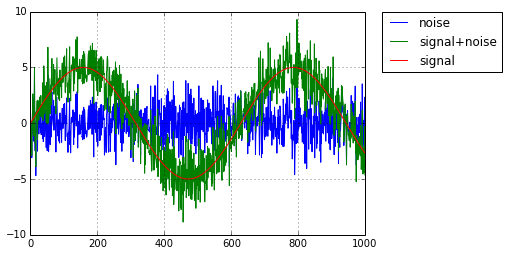

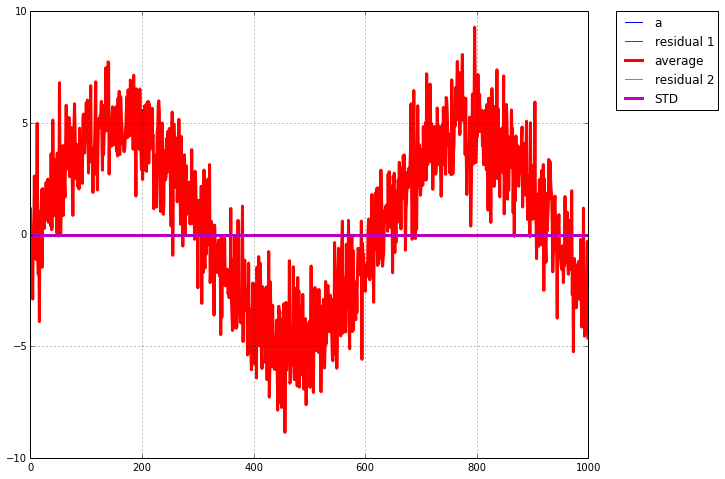

In [10]:
sz=1000; # length of input vector
scale=100.0
noise=np.random.normal(loc=0,scale=1.5,size=sz) #noise
signal=5*np.sin(np.arange(0,sz/scale,1/scale)) #signal
a= signal+noise
plt.plot(noise,label='noise')
plt.plot(a,label='signal+noise')
plt.plot(signal,label='signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

#Try: alpha=0.05,0.01,0
#Try: signal without noise. 
plot_mean_std(a,alpha=1)


### Equivalence between white noise and Minimal Squared Error.

The density function of the normal distribution with mean $\mu$ and std $\sigma=1$ is:
$$f(x, \mu, 1) = \frac{1}{ \sqrt{2\pi} } e^{ -\frac{(x-\mu)^2}{2} }$$

Assuming a stationary model, the probability density associated with a sample $x_1,\ldots,x_T$ is the product of the densities:
$$f(\{x_1,\ldots,x_T\}, \mu, 1) = 
\prod_{t=1}^T \frac{1}{\sqrt{2\pi} } e^{ -\frac{(x_t-\mu)^2}{2} } $$

If we use the Maximal-a-posteriori (MAP) estimator, we can ignore the constant normalization factors: $\frac{1}{\sqrt{2\pi} }$. Taking the logs we get that MAP estimate of $\mu$ is the minimizer of:
$$ \frac{1}{2} \sum_{t=1}^T (x_t-\mu)^2 $$

In other words, it is the minimizer of the mean-square-error over the examples. It is not hard to show that the average of the $x_t$'s is the minimizer:
$$\mu_{min}=\frac{1}{T} \sum_{t=1}^T x_t$$

### Predictive power as a function of $\alpha$:
Our model at time $t$ depends on the elements of the sequence seen so far: $x_1,x_2,\ldots,x_t$.

We can use the model at time $t$ to predict $x_{t+1}$. This is useful by itself.
In addition, it provides an objective way to evaluate the parameters used to create the model, in particular, it gives us a way to choose $\alpha$.

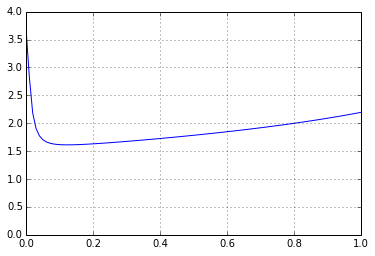

In [41]:
## This function takes as input an input sequence and a setting for alpha.
## It computes the Root Mean Square (RMS) error of the prediction.

def calc_RMS(a,alpha=0.0):
    sz=len(a)
    r1=np.zeros(sz)
    aver=np.zeros(sz)

    Av=run_aver(alpha=alpha)
    RMS=run_aver(alpha=0)

    for t in range(sz-1):
        r1[t]=Av.send(a[t])
        aver[t]=Av.get_state()
        error=(aver[t]-a[t+1])**2
        RMS.send(error)
    
    return(RMS.get_state())

alphas=np.arange(0,1.01,0.01)
rms=[]
for alpha in alphas:
    rms.append(np.sqrt(calc_RMS(a,alpha)))

plt.plot(alphas,rms)
plt.ylim(0,4)
plt.grid()

### DSE Class Work
Construct two sequences to be the sum of a sinusoidal signal and noise in the following four combinations.

Signal:
* Use the same signal for both sequences  (have at least 10 iterations/periods/waves in the data)
* make one sinusoid have double the wavelength as the other

Noise
* Use the same noise for both sequences
* Use independent noise for both sequence.

Create a function, similar to plot_mean_std which computes the (local) correlation coefficient between the two signals.

Create plots for the different signal pairs described above.